# Cerinta 1 - Reprezentarea modelului de clasificare

In [1]:
from copy import deepcopy
from json import dumps
from math import inf, log
import matplotlib.pyplot as plt
from operator import add
from os import listdir
from random import shuffle
from statistics import mean, stdev

import seaborn as sn
import pandas as pd

from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spacy import load

download('wordnet')
download('stopwords')

[nltk_data] Downloading package wordnet to /home/teo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/teo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class NewsClassificationModel:
    def __init__(self, stop_words_file, elim_stops, lemmatise):
        self._ALPHA = 1
        self._chars_to_remove = '012345679.,-~`|\\/:;\'"?![]()\n\"'
        self.elim_stops = elim_stops
        self.lemmatise = lemmatise

        self.class_words = {}
        self.class_app = {}
        self.total_words = {}
        self.total_files = 0
        self.voc = set()
        self.stop_pos = {'PART', 'DET', 'PUNCT', 'AUX'}

        self.wnl = WordNetLemmatizer()
        self.nlp = load('en')

        self.stop_words = set(stopwords.words('english')) | set(' ')
        with open(stop_words_file) as f:
            self.stop_words.union(set(token.replace('\n', '') for token in f))
    

    def _remove_chars(self, s):
        for ch in self._chars_to_remove:
            s = s.replace(ch, '')
        return s


    def _should_keep_token(self, tok):
        if self.elim_stops:
            if self.lemmatise:
                return (tok.lemma_ not in self.stop_words
                    and tok.pos_ not in self.stop_pos
                    and not tok.is_stop)
            else:
                return tok not in self.stop_words

        return True


    def _parse_file(self, file):
        lems = []
        # TODO: fa mai functional
        with open(file, encoding='utf8') as f:
            if self.lemmatise:
                tokens = self.nlp(f.read().replace('\n', ' '))
            else:
                tokens = f.read().replace('\n', ' ').split()

            for tok in tokens:
                if self._should_keep_token(tok):
                    if self.lemmatise:
                        lem = self.wnl.lemmatize(
                            self._remove_chars(tok.lemma_).lower()
                        )
                    else:
                        lem = tok

                    if lem and (
                        not self.elim_stops
                        or lem not in self.stop_words
                    ):
                        lems.append(lem)

        return lems


    def add_file(self, file, clss):
        self.total_files += 1

        if clss in self.class_app:
            self.class_app[clss] += 1
        else:
            self.class_app[clss] = 1
            self.class_words[clss] = {}
            self.total_words[clss] = 0

        for lem in self._parse_file(file):
            self.total_words[clss] += 1
            self.voc.add(lem)

            if lem in self.class_words[clss]:
                self.class_words[clss][lem] += 1
            else:
                self.class_words[clss][lem] = 1


    def _compute_log_prob(self, word, cl):
        return log(
            (self.class_words[cl].get(word, 0) + self._ALPHA)
            / (self.total_words[cl] + len(self.voc) * self._ALPHA)
        )


    def run_inference(self, file):
        max_prob = -inf
        lems = self._parse_file(file)

        for cl in self.class_words:
            cl_prob = sum(
                map(lambda l: self._compute_log_prob(l, cl), lems),
                log(self.class_app[cl] / self.total_files)
            )

            if max_prob < cl_prob:
                max_prob = cl_prob
                pred = cl

        return pred

In [3]:
def _get_train_test_files(path, stop_words_file):
    train_files = []
    test_files = []
    classes = listdir(path)

    for clss in classes:
        files_in_class = list(map(
            lambda f: (clss, f'{path}/{clss}/{f}'),
            listdir(f'{path}/{clss}')
        ))
        shuffle(files_in_class)
        num_tests = int(len(files_in_class) / 4)
    
        test_files += files_in_class[:num_tests]
        train_files += files_in_class[num_tests:]

    shuffle(train_files)
    return train_files, test_files, classes


def _run_tests(model, test_files, classes):
    precs = {}
    recalls = {}
    total_preds = {}
    conf = []

    preds = list(map(
        lambda t: (t[0], model.run_inference(t[1])),
        test_files
    ))

    for clss in classes:
        correct_preds = len(list(filter(
            lambda p: clss == p[1] and p[0] == p[1],
            preds
        )))
        preds_for_class = list(filter(lambda p: clss == p[0], preds))
        files_class = len(preds_for_class)
        preds_class = len(list(filter(lambda p: clss == p[1], preds)))

        conf.append([len(list(filter(lambda p: cl == p[1], preds_for_class))) / files_class
            for cl in classes])        

        precs[clss] = correct_preds / preds_class
        recalls[clss] = correct_preds / files_class

    return recalls, precs, conf


def _display_results(xs, precs, recalls, confusion, elim_stops, lemmatise):
    lem = 'cu' if lemmatise else 'fara'
    elim = 'cu' if elim_stops else 'fara'

    sn.set(font_scale=1.5)
    df = pd.DataFrame(confusion, index=precs.keys(), columns=precs.keys())
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, annot=True, annot_kws={"size": 16})

    plt.title(f'Matricea de confuzie {lem} lematizare, {elim} eliminarea cuvintelor neinformative', fontsize=20)
    plt.show()

    for clss in precs:
        plt.figure(figsize=(23,5))
        plt.plot(xs, precs[clss], label='Precizie')
        plt.plot(xs, recalls[clss], label='Regasire')
        
        plt.xlabel('Fisierele de antrenament', fontsize=20)
        plt.ylabel('Procentaj', fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        plt.legend(fontsize=20)
        plt.title(f'Precizia si regasirea clasei "{clss}", {lem} lematizare, {elim} eliminarea cuvintelor neinformative', fontsize=20)

        plt.show()


def train_and_test(path, stop_words_file, elim_stops, lemmatise):
    model = NewsClassificationModel(stop_words_file, elim_stops, lemmatise)
    train_files, test_files, classes = _get_train_test_files(path, stop_words_file,)

    precs = {clss: [] for clss in classes}
    recalls = deepcopy(precs)
    xs = []
    i = 1

    for clss, file in train_files:
        if i % 100 == 0:
            xs.append(i)
            rec, prec, _ = _run_tests(model, test_files, classes)
            for cl in classes:
                recalls[cl].append(rec[cl])
                precs[cl].append(prec[cl])

        model.add_file(file, clss)
        i += 1
    
    xs.append(i)
    rec, prec, confusion = _run_tests(model, test_files, classes)
    for cl in classes:
        recalls[cl].append(rec[cl])
        precs[cl].append(prec[cl])

    _display_results(xs, precs, recalls, confusion, elim_stops, lemmatise)


def _get_file_groups(path, num_groups):
    classes = listdir(path)
    files = []

    for clss in classes:
        files += list(map(
            lambda f: (clss, f'{path}/{clss}/{f}'),
            listdir(f'{path}/{clss}')
        ))

    num_files = len(files)
    chunk_size = int(num_files / num_groups)

    shuffle(files)
    file_groups = [files[i*chunk_size : (i+1)*chunk_size]
        for i in range(num_groups)]

    return file_groups, classes


def train_test_cross_validate(
    path,
    stop_words_file,
    elim_stops,
    lemmatise,
    num_groups
):
    file_groups, classes = _get_file_groups(path, num_groups)

    results = {clss: {'precision': {}, 'recall': {}}
        for clss in classes}
    precs = {clss: [] for clss in classes}
    recalls = deepcopy(precs)

    for i in range(len(file_groups)):
        test_files = file_groups[i]
        train_groups = file_groups[:i] + file_groups[i+1:]
        train_files = sum(train_groups, [])

        model = NewsClassificationModel(stop_words_file, elim_stops, lemmatise)
        [model.add_file(file, clss) for clss, file in train_files]

        prec, rec, _ = _run_tests(model, test_files, classes)
        for clss in classes:
            precs[clss].append(prec[clss])
            recalls[clss].append(rec[clss])

    for clss in classes:
        results[clss]['precision']['mean'] = mean(precs[clss])
        results[clss]['recall']['mean'] = mean(recalls[clss])
        results[clss]['precision']['stddev'] = stdev(precs[clss])
        results[clss]['recall']['stddev'] = stdev(recalls[clss])

    print(dumps(results, indent=4))

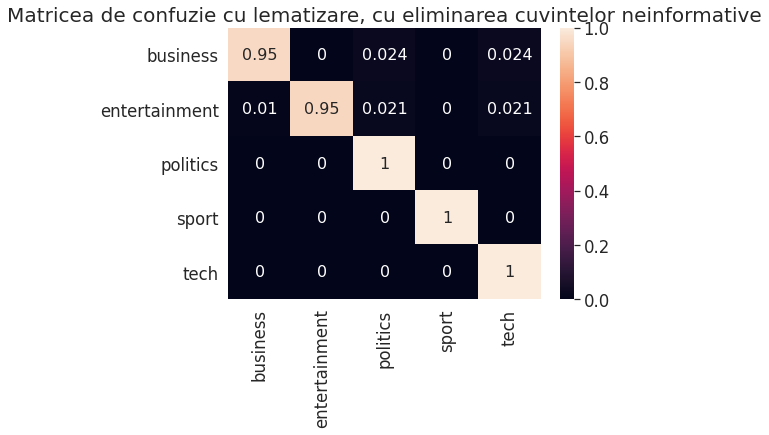

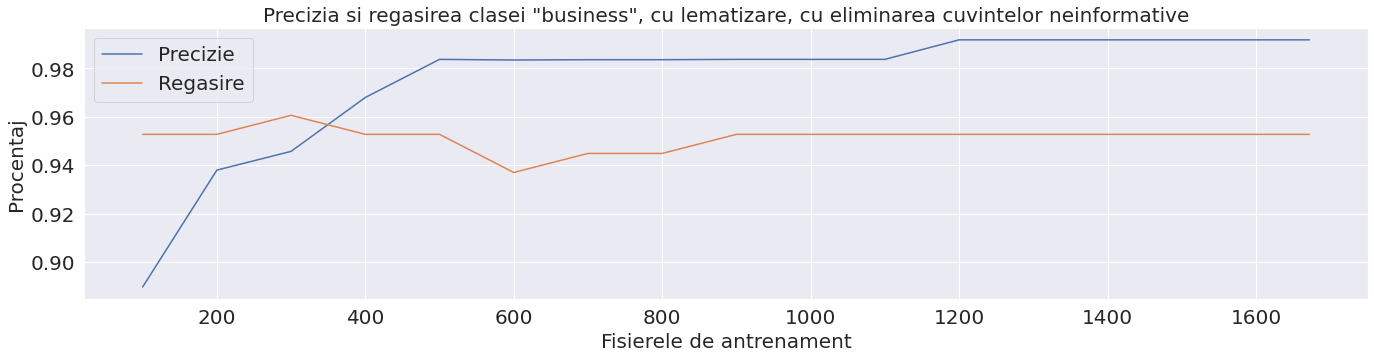

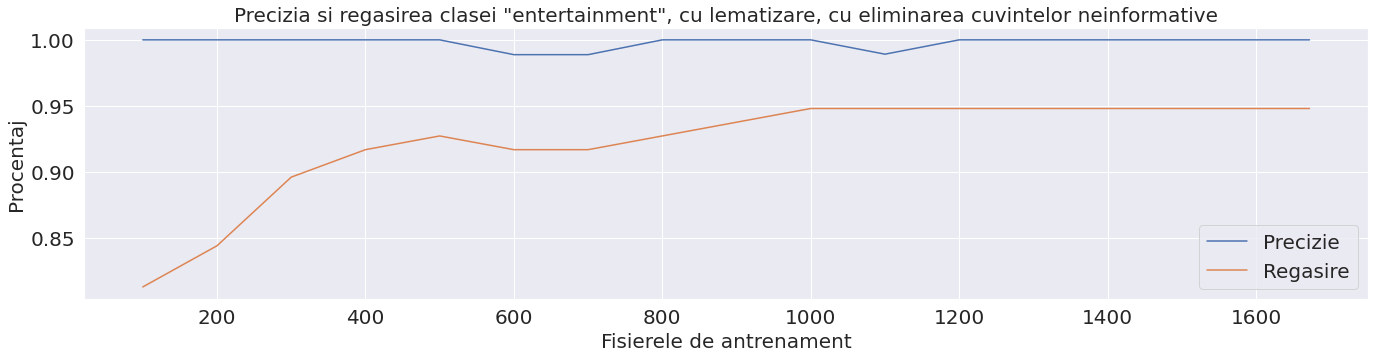

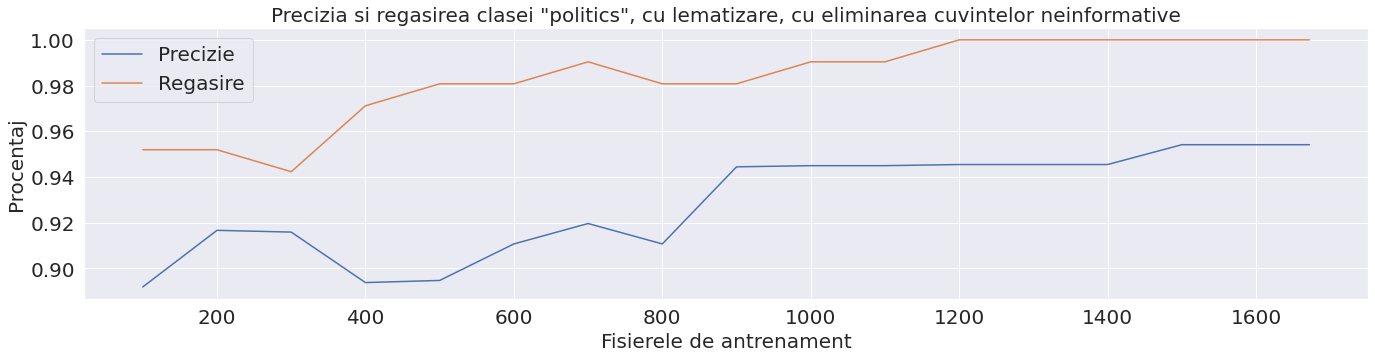

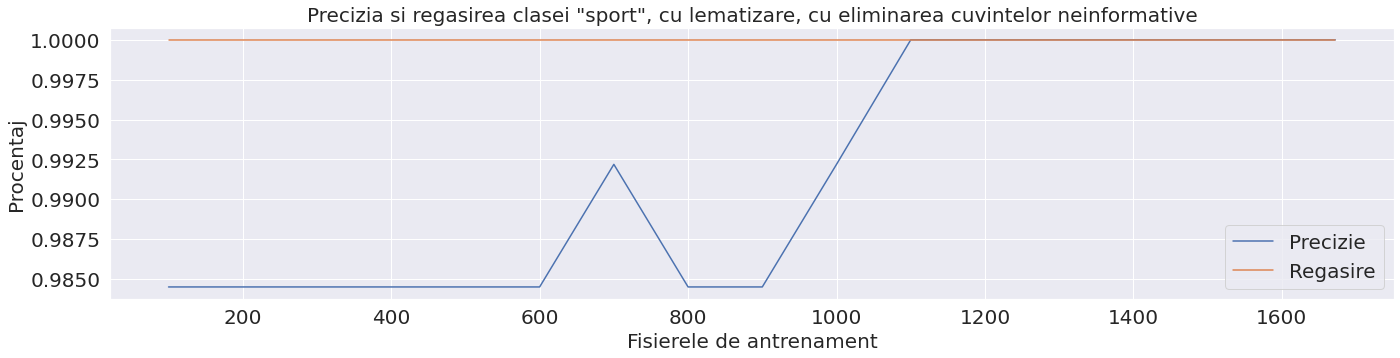

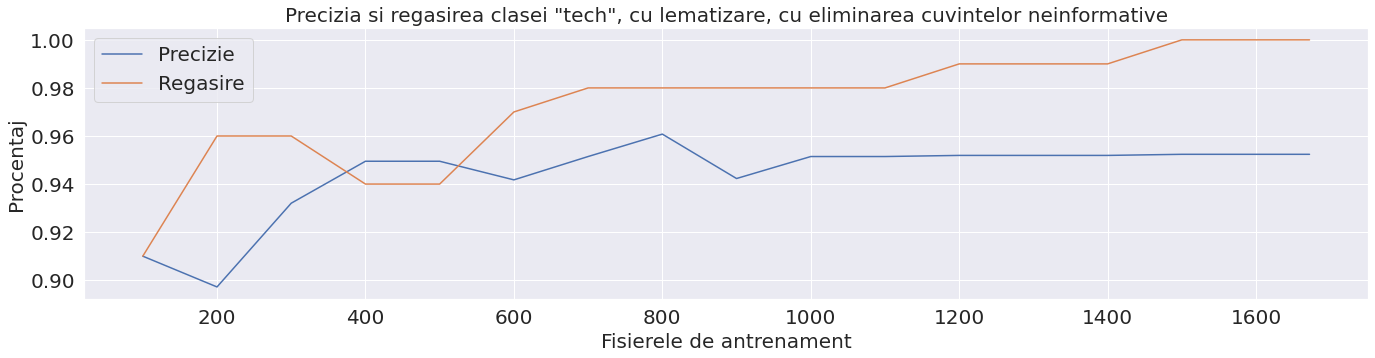

In [4]:
train_and_test('BBC News Summary/News Articles', 'stop_words', True, True)

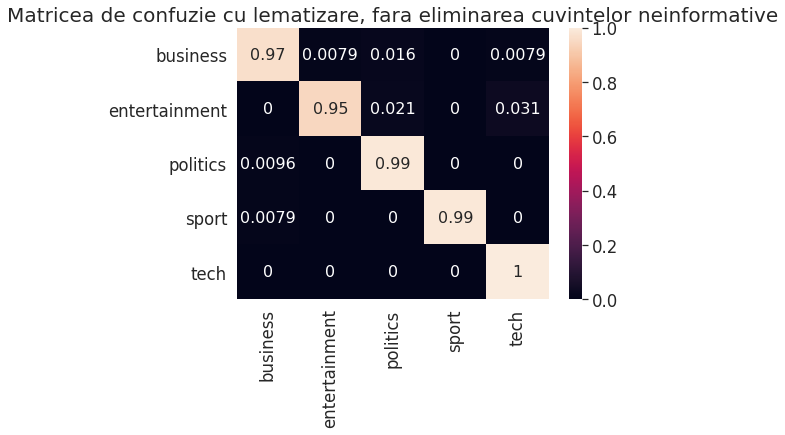

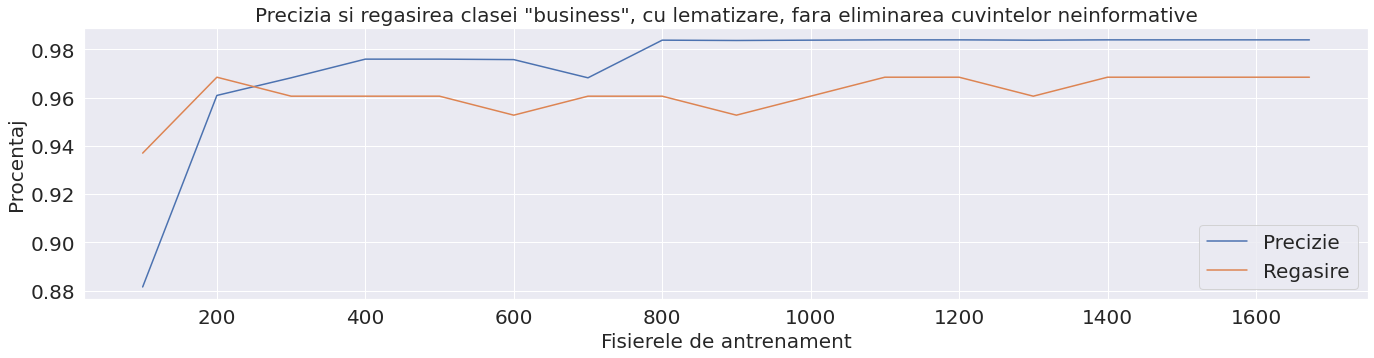

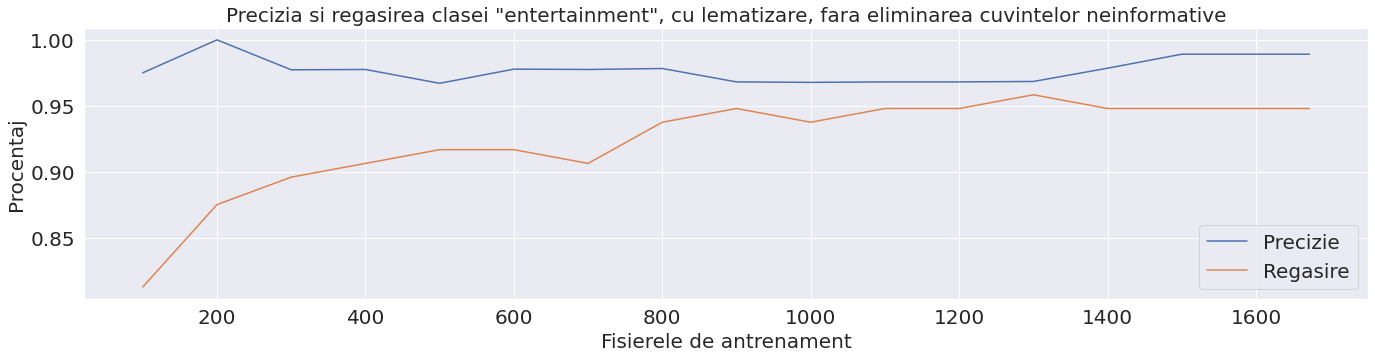

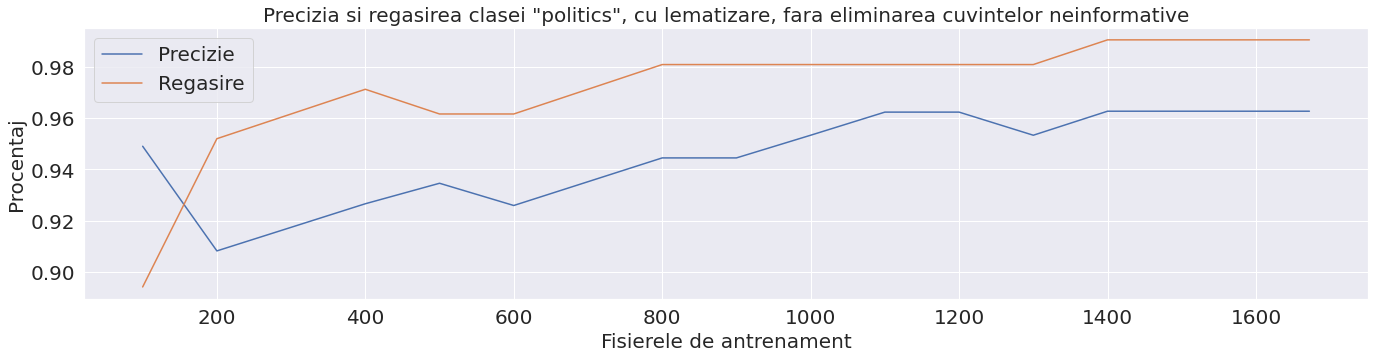

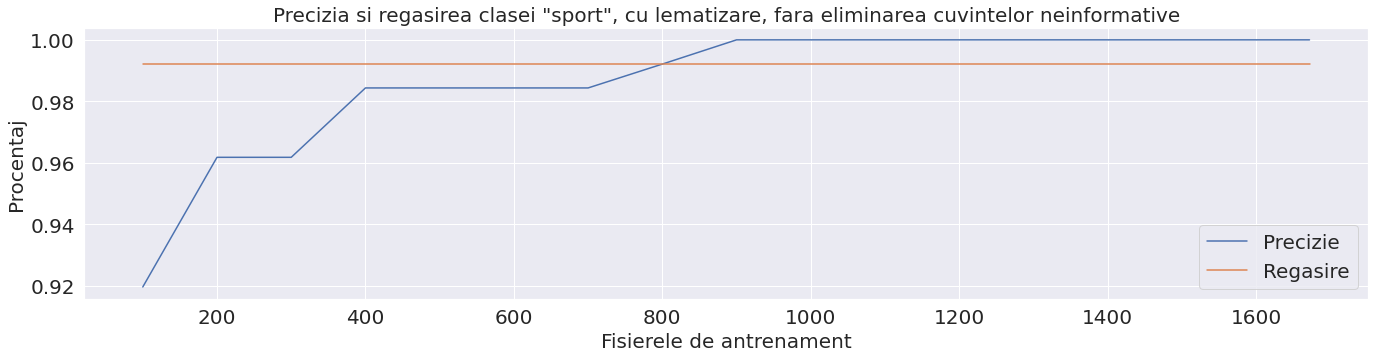

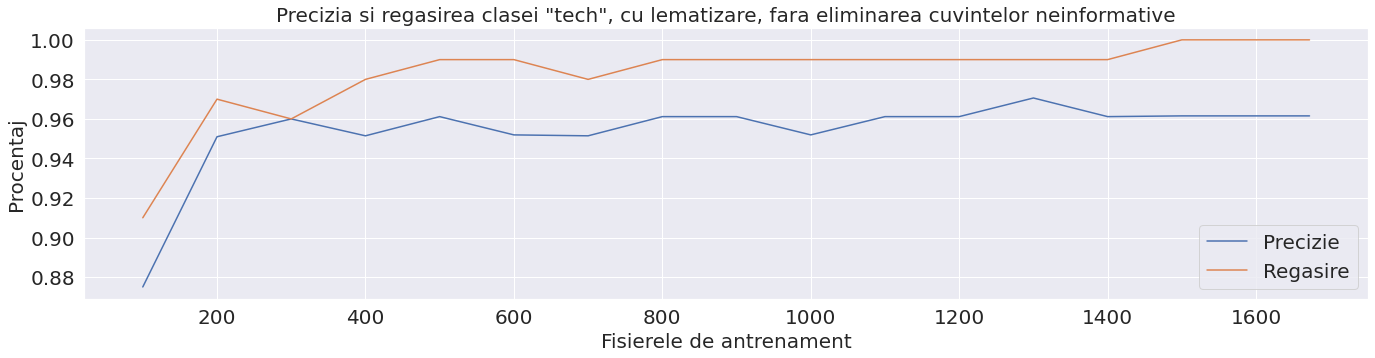

In [5]:
train_and_test('BBC News Summary/News Articles', 'stop_words', False, True)

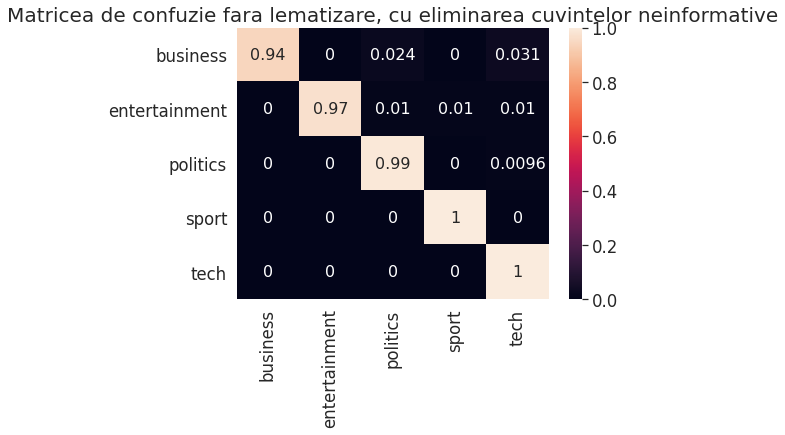

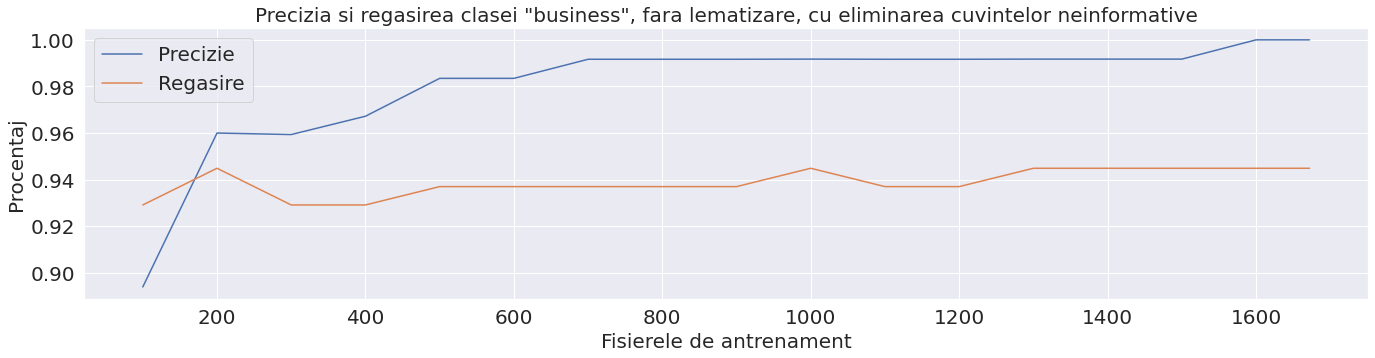

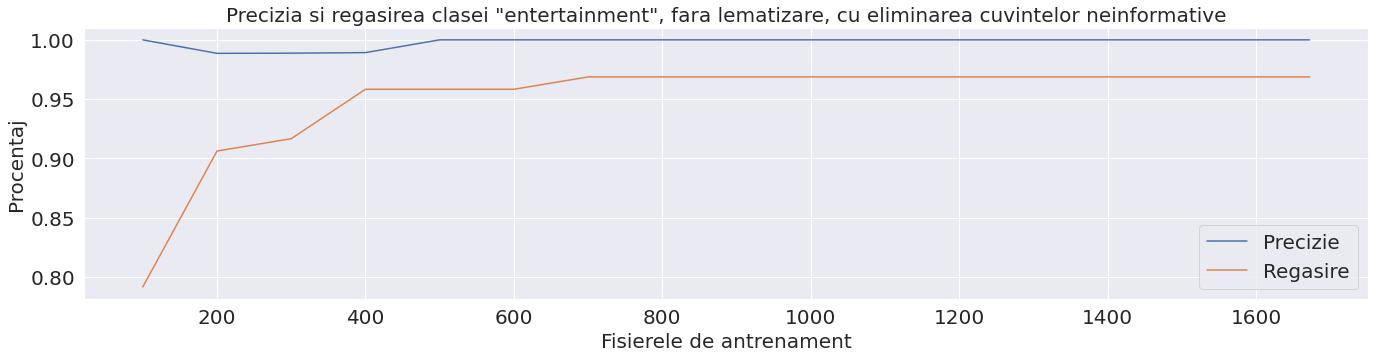

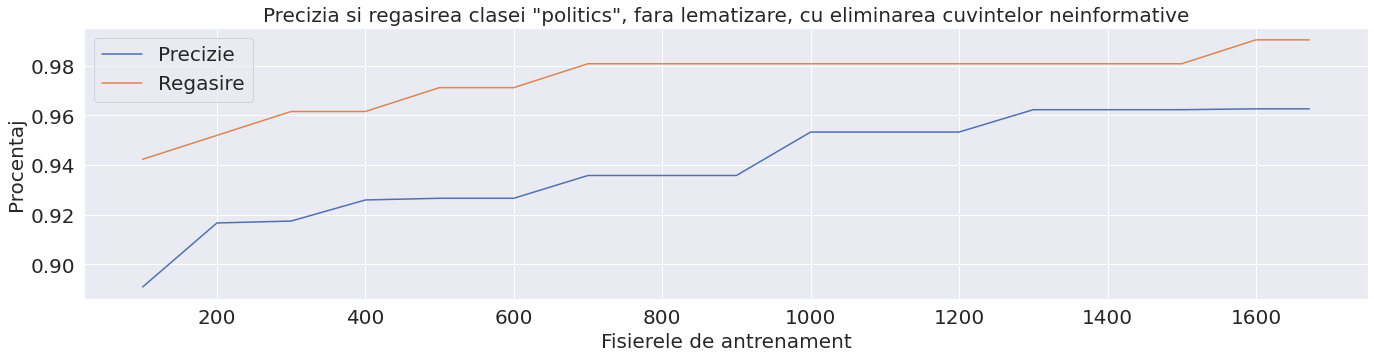

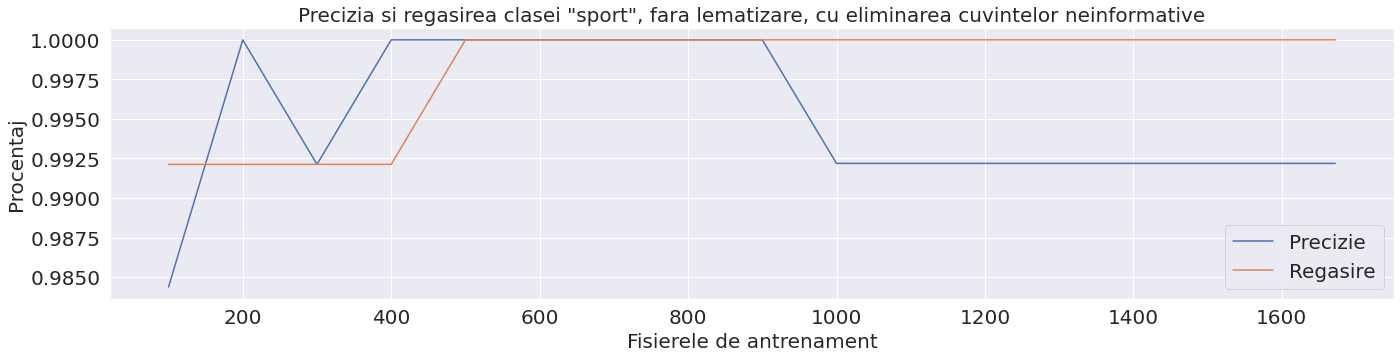

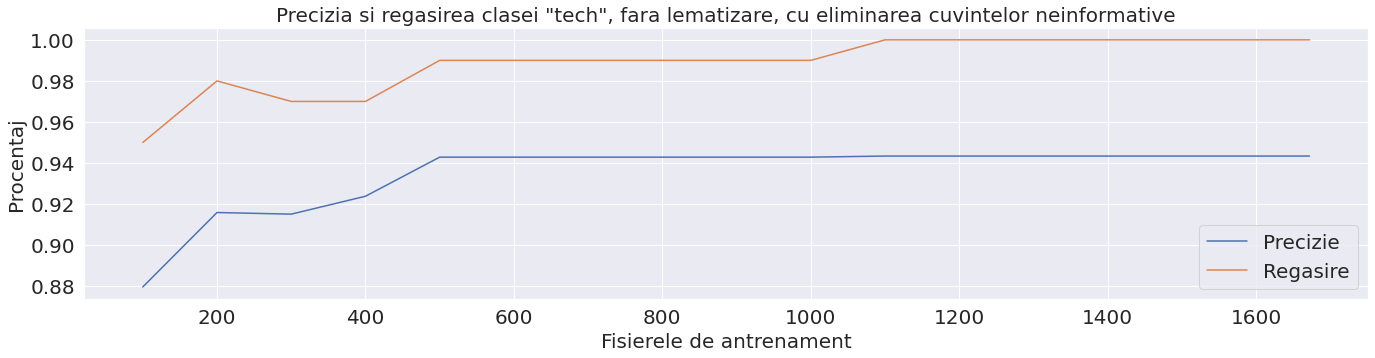

In [6]:
train_and_test('BBC News Summary/News Articles', 'stop_words', True, False)

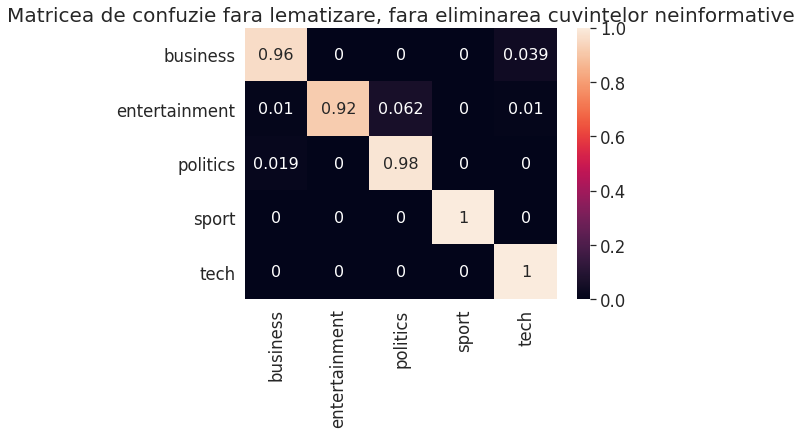

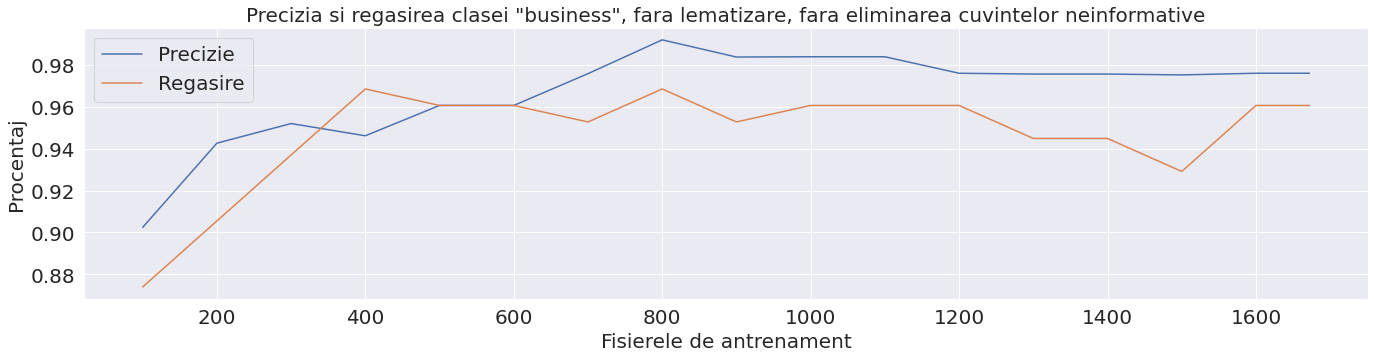

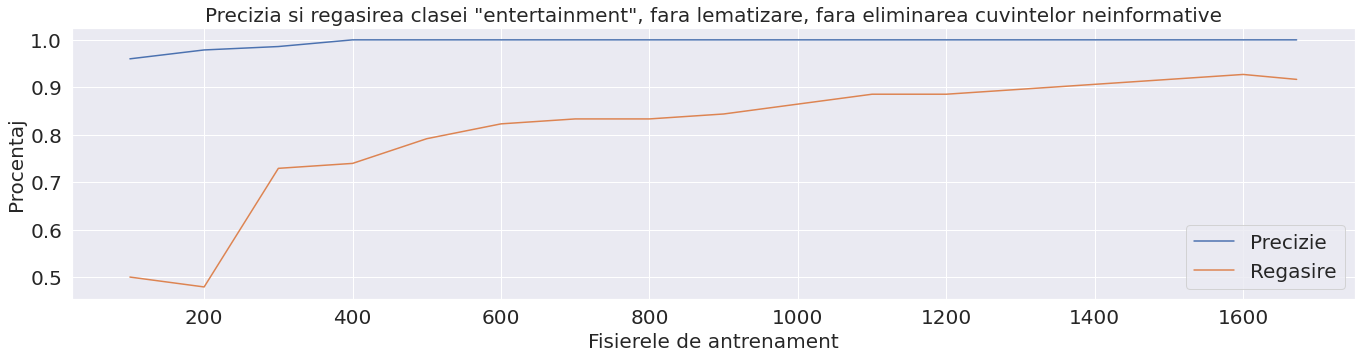

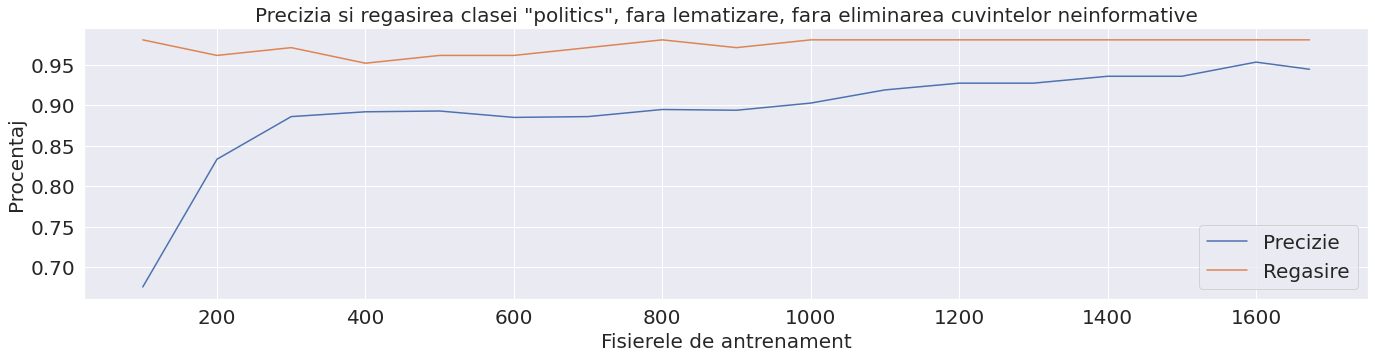

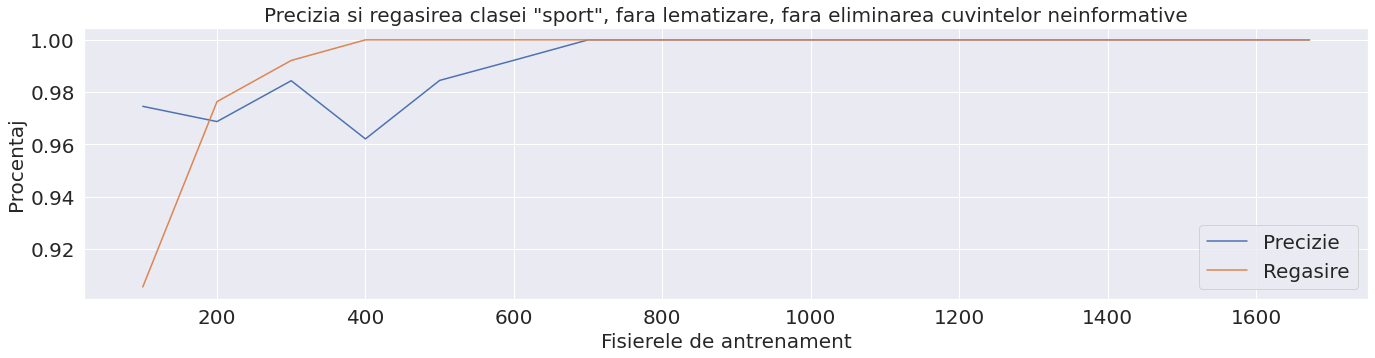

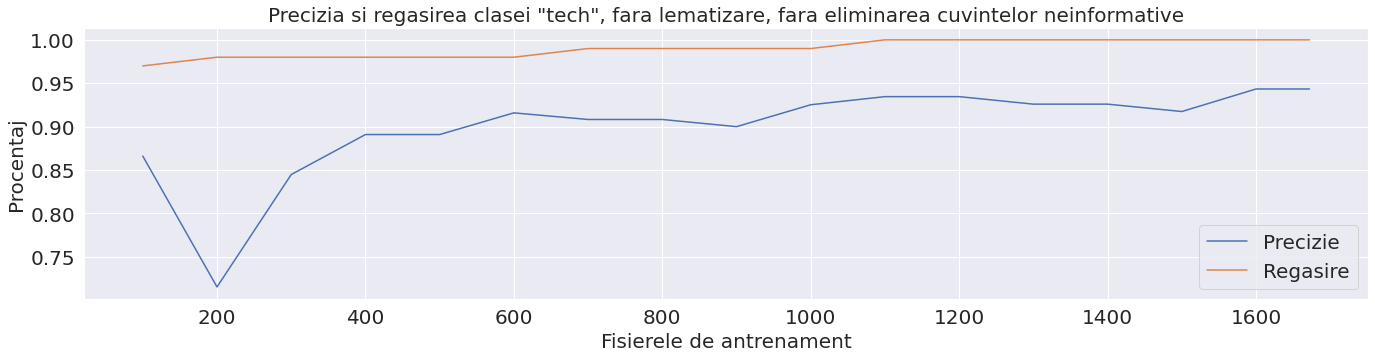

In [7]:
train_and_test('BBC News Summary/News Articles', 'stop_words', False, False)

In [8]:
train_test_cross_validate('BBC News Summary/News Articles', 'stop_words', True, True, 5)

{
    "business": {
        "precision": {
            "mean": 0.957153023890888,
            "stddev": 0.02475583418913489
        },
        "recall": {
            "mean": 0.9840662415640324,
            "stddev": 0.008357078203831178
        }
    },
    "entertainment": {
        "precision": {
            "mean": 0.9590017333321798,
            "stddev": 0.026831524451578322
        },
        "recall": {
            "mean": 0.9896014492753623,
            "stddev": 0.010614148832079359
        }
    },
    "politics": {
        "precision": {
            "mean": 0.9837107705466956,
            "stddev": 0.01349555804476172
        },
        "recall": {
            "mean": 0.9488758043595952,
            "stddev": 0.018136822049430925
        }
    },
    "sport": {
        "precision": {
            "mean": 0.9946684219187099,
            "stddev": 0.007736354739693847
        },
        "recall": {
            "mean": 0.9978260869565218,
            "stddev": 0.004861017342390

In [9]:
train_test_cross_validate('BBC News Summary/News Articles', 'stop_words', True, False, 5)

{
    "business": {
        "precision": {
            "mean": 0.9561413095688408,
            "stddev": 0.019749119584143077
        },
        "recall": {
            "mean": 0.9859350972731835,
            "stddev": 0.008608178932716745
        }
    },
    "entertainment": {
        "precision": {
            "mean": 0.948087957019921,
            "stddev": 0.02514844042387467
        },
        "recall": {
            "mean": 0.9865094503207907,
            "stddev": 0.01678377754945138
        }
    },
    "politics": {
        "precision": {
            "mean": 0.9886807760141093,
            "stddev": 0.011300026093982587
        },
        "recall": {
            "mean": 0.9549607483412191,
            "stddev": 0.02122233270628869
        }
    },
    "sport": {
        "precision": {
            "mean": 0.9960233918128655,
            "stddev": 0.005507641954606357
        },
        "recall": {
            "mean": 0.9980392156862745,
            "stddev": 0.0043844470147054

In [10]:
train_test_cross_validate('BBC News Summary/News Articles', 'stop_words', False, True, 5)

{
    "business": {
        "precision": {
            "mean": 0.9560470569117434,
            "stddev": 0.014814746465384183
        },
        "recall": {
            "mean": 0.9820632405222199,
            "stddev": 0.007294916263611503
        }
    },
    "entertainment": {
        "precision": {
            "mean": 0.9544809500199731,
            "stddev": 0.029662306880840577
        },
        "recall": {
            "mean": 0.9892172472660278,
            "stddev": 0.006145103819069613
        }
    },
    "politics": {
        "precision": {
            "mean": 0.9833961331274714,
            "stddev": 0.010002459268708592
        },
        "recall": {
            "mean": 0.9512102946169316,
            "stddev": 0.013287615152372367
        }
    },
    "sport": {
        "precision": {
            "mean": 0.9958762886597938,
            "stddev": 0.00922089887628781
        },
        "recall": {
            "mean": 1.0,
            "stddev": 0.0
        }
    },
    "tech

In [11]:
train_test_cross_validate('BBC News Summary/News Articles', 'stop_words', False, False, 5)

{
    "business": {
        "precision": {
            "mean": 0.944666271672522,
            "stddev": 0.019869107208515372
        },
        "recall": {
            "mean": 0.9818064806480647,
            "stddev": 0.012867489353045049
        }
    },
    "entertainment": {
        "precision": {
            "mean": 0.9299546624546624,
            "stddev": 0.02155974239821293
        },
        "recall": {
            "mean": 0.9941919191919192,
            "stddev": 0.007965560755347208
        }
    },
    "politics": {
        "precision": {
            "mean": 0.9825325162322394,
            "stddev": 0.012915070615618704
        },
        "recall": {
            "mean": 0.9341669749141466,
            "stddev": 0.02680059720359666
        }
    },
    "sport": {
        "precision": {
            "mean": 0.9939425918108906,
            "stddev": 0.008827865566222406
        },
        "recall": {
            "mean": 0.9980392156862745,
            "stddev": 0.004384447014705